In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np

In [81]:
#Cargue de los datos
sp_500 = pd.read_csv('D:\Talento_Tech\AVD_Intermedio\Componente_Tecnico\Proyecto\SP_Analysis\data\S&P500_prices_proccessed.csv')

sp_500.head(4)

,Date,Symbol,Close
0,2024-01-02,MMM,89.846542
1,2024-01-03,MMM,88.041451
2,2024-01-04,MMM,88.351830
3,2024-01-05,MMM,88.694878


In [82]:
sp_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29890 entries, 0 to 29889
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    29890 non-null  object 
 1   Symbol  29890 non-null  object 
 2   Close   29890 non-null  float64
dtypes: float64(1), object(2)
memory usage: 700.7+ KB


In [83]:
#Convertir Columna Date a formato fecha
sp_500['Date']  = pd.to_datetime(sp_500['Date'])

#Ordenar los valores
sp_500 = sp_500.sort_values(by=['Symbol', 'Date'])

print(sp_500.info())
print(sp_500.head(4))

<class 'pandas.core.frame.DataFrame'>
Index: 29890 entries, 671 to 29889
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    29890 non-null  datetime64[ns]
 1   Symbol  29890 non-null  object        
 2   Close   29890 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 934.1+ KB
None
          Date Symbol       Close
671 2024-01-02      A  138.268341
672 2024-01-03      A  130.704697
673 2024-01-04      A  130.545242
674 2024-01-05      A  130.106781


In [84]:
#Calcular la columna de retorno
sp_500['Return'] = sp_500.groupby('Symbol')['Close'].pct_change()*100

#Borrar valores nulos
sp_500 = sp_500.dropna()

print(sp_500.head(4))
print(sp_500.info())

          Date Symbol       Close    Return
672 2024-01-03      A  130.704697 -5.470265
673 2024-01-04      A  130.545242 -0.121996
674 2024-01-05      A  130.106781 -0.335869
675 2024-01-08      A  132.916992  2.159927
<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 672 to 29889
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    29400 non-null  datetime64[ns]
 1   Symbol  29400 non-null  object        
 2   Close   29400 non-null  float64       
 3   Return  29400 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.1+ MB
None


In [85]:
#Crear la tabla de retorno
return_std = sp_500.groupby('Symbol')['Return'].std().reset_index()

#Dar nombre a la columna 
return_std.rename(columns={return_std.columns[1] :'return_std'}, inplace=True)

return_std.head(4)

,Symbol,return_std
0,A,1.574247
1,AAL,2.906129
2,AAP,2.132842
3,AAPL,1.258356


In [86]:
#Crear tabla rango
rango = sp_500.groupby('Symbol')['Return'].apply(lambda x: x.max() - x.min()).reset_index()
rango.rename(columns={'Return':'Rango'}, inplace=True)
rango.head(4)

,Symbol,Rango
0,A,8.835034
1,AAL,19.724143
2,AAP,11.464274
3,AAPL,7.342810


In [87]:
#Crear tabla valor absoluto
absolute = sp_500.groupby('Symbol')['Return'].apply(lambda x: abs(x.mean())).reset_index()
absolute.rename(columns={'Return': 'Media_Abs'}, inplace=True)
absolute.head(4)

,Symbol,Media_Abs
0,A,0.091579
1,AAL,0.262953
2,AAP,0.559389
3,AAPL,0.122219


In [88]:
#Unificación de todas las métricas de volatilidad
volatilidad = pd.DataFrame()

volatilidad['Symbol'] = sp_500['Symbol'].drop_duplicates()

#Agregar desviación estándar del retorno, el rango y la media absoluta
volatilidad = volatilidad.merge(return_std, how='inner', on='Symbol')
volatilidad = volatilidad.merge(rango, how='inner', on='Symbol')
volatilidad = volatilidad.merge(absolute, how='inner', on='Symbol')


volatilidad.head(4)

,Symbol,return_std,Rango,Media_Abs
0,A,1.574247,8.835034,0.091579
1,AAL,2.906129,19.724143,0.262953
2,AAP,2.132842,11.464274,0.559389
3,AAPL,1.258356,7.342810,0.122219


In [89]:
volatilidad.describe()

,return_std,Rango,Media_Abs
count,490.000000,490.000000,490.000000
mean,1.604372,9.428463,0.185481
std,0.743796,5.163183,0.145265
min,0.591706,3.046898,0.000035
25%,1.160557,6.176115,0.071660
50%,1.414995,7.873594,0.159496
75%,1.876707,11.111844,0.267803
max,10.765176,56.507015,1.102319


<Axes: >

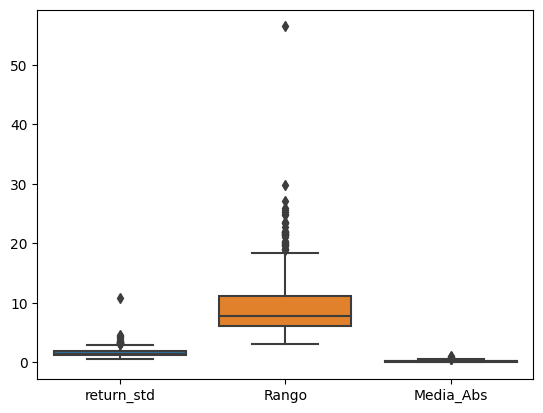

In [90]:
sns.boxplot(volatilidad)

In [91]:
#Eliminar los outliers basado en el rango intercuartilico del rango

# Calcular Q1 (cuartil 25%) y Q3 (cuartil 75%)
Q1 = volatilidad['Rango'].quantile(0.25)
Q3 = volatilidad['Rango'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites de los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para eliminar los outliers
volatilidad_sin = volatilidad[(volatilidad['Rango'] >= lower_bound) & (volatilidad['Rango'] <= upper_bound)]
volatilidad_sin = volatilidad_sin.copy()

print(volatilidad_sin.head(4))
print(volatilidad_sin.info())


  Symbol  return_std      Rango  Media_Abs
0      A    1.574247   8.835034   0.091579
2    AAP    2.132842  11.464274   0.559389
3   AAPL    1.258356   7.342810   0.122219
4   ABBV    0.861816   3.898611   0.237289
<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 489
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Symbol      456 non-null    object 
 1   return_std  456 non-null    float64
 2   Rango       456 non-null    float64
 3   Media_Abs   456 non-null    float64
dtypes: float64(3), object(1)
memory usage: 17.8+ KB
None


In [92]:
#Estandarización de las métricas de volatilidad

#Calcular return_Std Z score 
return_std_mean = volatilidad_sin['return_std'].mean()
return_std_std = volatilidad_sin['return_std'].std()

volatilidad_sin.loc[:,'return_std_Z'] = volatilidad_sin['return_std'].apply(lambda x: (x - return_std_mean) / return_std_std)

#Calcular Rango Z score 
Rango_mean = volatilidad_sin['Rango'].mean()
Rango_std = volatilidad_sin['Rango'].std()

volatilidad_sin.loc[:,'Rango_Z'] = volatilidad_sin['Rango'].apply(lambda x: (x - Rango_mean) / Rango_std)

#Calcular Media_ABS Z score 
Media_Abs_mean = volatilidad_sin['Media_Abs'].mean()
Media_Abs_std = volatilidad_sin['Media_Abs'].std()

volatilidad_sin.loc[:,'Media_Abs_Z'] = volatilidad_sin['Media_Abs'].apply(lambda x: (x - Media_Abs_mean) / Media_Abs_std)


volatilidad_sin.head(3)


,Symbol,return_std,Rango,Media_Abs,return_std_Z,Rango_Z,Media_Abs_Z
0,A,1.574247,8.835034,0.091579,0.214605,0.133640,-0.659895
2,AAP,2.132842,11.464274,0.559389,1.438953,0.946151,2.984236
3,AAPL,1.258356,7.342810,0.122219,-0.477775,-0.327501,-0.421223


In [93]:
#Normalización de las métricas de volatilidad

#Normalizacion de return
return_max = volatilidad_sin['return_std'].max()
return_min = volatilidad_sin['return_std'].min()


volatilidad_sin.loc[:,'return_std_norm'] = volatilidad_sin['return_std'].apply(lambda x: (x - return_min)/ (return_max - return_min))

#Normalizacion de Rango
rango_max = volatilidad_sin['Rango'].max()
rango_min = volatilidad_sin['Rango'].min()


volatilidad_sin.loc[:,'Rango_Norm'] = volatilidad_sin['Rango'].apply(lambda x: (x - rango_min)/ (rango_max - rango_min))

#Normalizacion de Media_Abs

Media_Abs_max = volatilidad_sin['Media_Abs'].max()
Media_Abs_min = volatilidad_sin['Media_Abs'].min()


volatilidad_sin.loc[:,'Media_Abs_Norm'] = volatilidad_sin['Media_Abs'].apply(lambda x: (x - Media_Abs_min)/ (Media_Abs_max - Media_Abs_min))


volatilidad_sin.head(3)

,Symbol,return_std,Rango,Media_Abs,return_std_Z,Rango_Z,Media_Abs_Z,return_std_norm,Rango_Norm,Media_Abs_Norm
0,A,1.574247,8.835034,0.091579,0.214605,0.133640,-0.659895,0.362280,0.377505,0.162622
2,AAP,2.132842,11.464274,0.559389,1.438953,0.946151,2.984236,0.568243,0.548986,0.993650
3,AAPL,1.258356,7.342810,0.122219,-0.477775,-0.327501,-0.421223,0.245805,0.280182,0.217050


<Axes: >

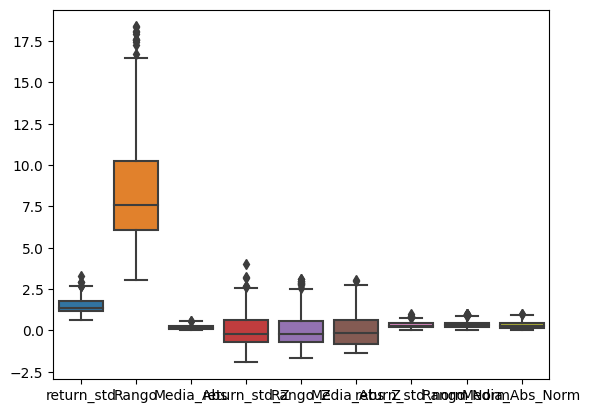

In [94]:
sns.boxplot(volatilidad_sin)

In [95]:
volatilidad_Z = volatilidad_sin[['Symbol', 'return_std_Z', 'Rango_Z', 'Media_Abs_Z']]
volatilidad_Norm = volatilidad_sin[['Symbol', 'return_std_norm', 'Rango_Norm', 'Media_Abs_Norm']]

print(volatilidad_Z.head(3))
print(volatilidad_Norm.head(3))

  Symbol  return_std_Z   Rango_Z  Media_Abs_Z
0      A      0.214605  0.133640    -0.659895
2    AAP      1.438953  0.946151     2.984236
3   AAPL     -0.477775 -0.327501    -0.421223
  Symbol  return_std_norm  Rango_Norm  Media_Abs_Norm
0      A         0.362280    0.377505        0.162622
2    AAP         0.568243    0.548986        0.993650
3   AAPL         0.245805    0.280182        0.217050


In [96]:
volatilidad_Norm['return_std_norm'].max()

1.0

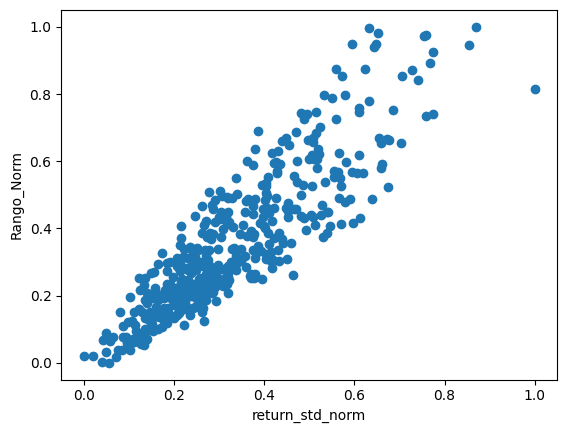

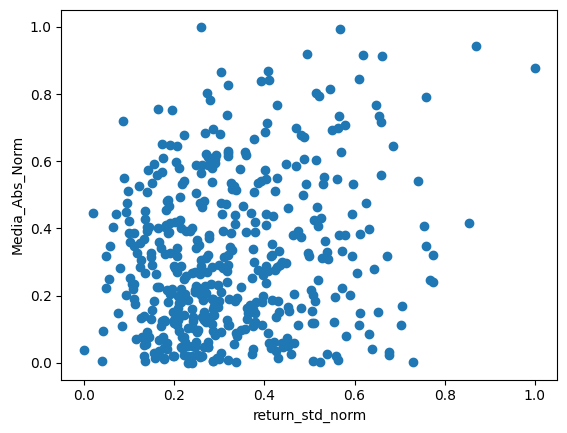

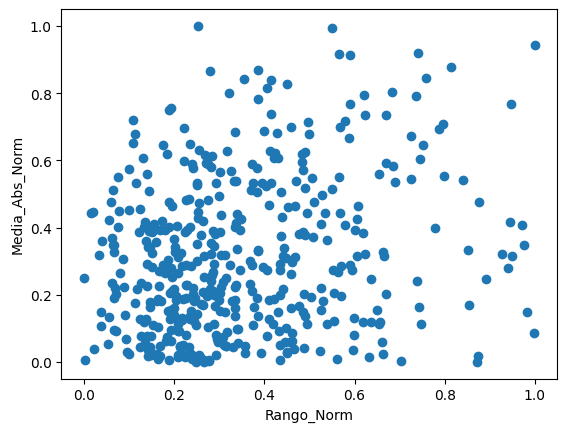

In [97]:
plt.scatter(volatilidad_Norm.iloc[:,1], volatilidad_Norm.iloc[:,2])
plt.xlabel(volatilidad_Norm.columns[1])
plt.ylabel(volatilidad_Norm.columns[2])
plt.show()
plt.scatter(volatilidad_Norm.iloc[:,1], volatilidad_Norm.iloc[:,3])
plt.xlabel(volatilidad_Norm.columns[1])
plt.ylabel(volatilidad_Norm.columns[3])
plt.show()
plt.scatter(volatilidad_Norm.iloc[:,2], volatilidad_Norm.iloc[:,3])
plt.xlabel(volatilidad_Norm.columns[2])
plt.ylabel(volatilidad_Norm.columns[3])
plt.show()

Cargas (Loadings):
                      PC1       PC2
return_std_norm  0.147217 -0.064385
Rango_Norm       0.191459 -0.079910
Media_Abs_Norm   0.134604  0.184082

Varianza Explicada de Cada Variable en Cada Componente:
                      PC1       PC2
return_std_norm  0.001657  0.000184
Rango_Norm       0.002802  0.000284
Media_Abs_Norm   0.001385  0.001505


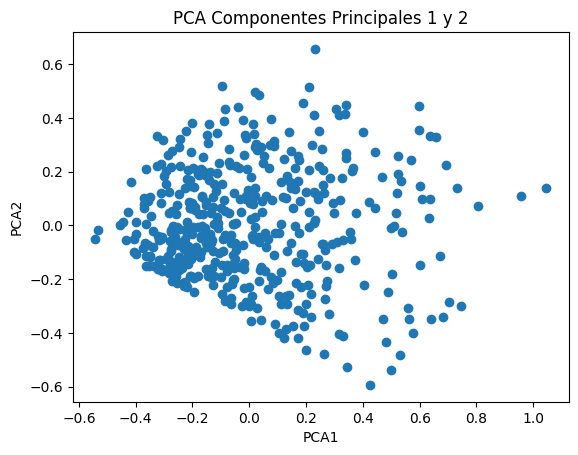

In [98]:
#Método de reducción de dimensionalidad

columns = ['return_std_norm', 'Rango_Norm', 'Media_Abs_Norm']

pca = PCA(n_components=2)
pca.fit(volatilidad_sin[columns])

transform_pca = pca.transform(volatilidad_sin[columns])

# Obtener las cargas
# Las cargas se obtienen multiplicando los componentes por la raíz cuadrada de la varianza explicada
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Convertir a DataFrame para una mejor visualización
loadings_df = pd.DataFrame(loadings, index=columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Calcular la varianza explicada de cada variable en cada componente
explained_variance = np.square(loadings) * pca.explained_variance_
explained_variance_df = pd.DataFrame(explained_variance, index=columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print("Cargas (Loadings):")
print(loadings_df)
print("\nVarianza Explicada de Cada Variable en Cada Componente:")
print(explained_variance_df)


plt.scatter(transform_pca[:,0], transform_pca[:,1])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Componentes Principales 1 y 2')
plt.show()

volatilidad_sin['PCA1'] = transform_pca[:,0]
volatilidad_sin['PCA2'] = transform_pca[:,1]

In [99]:
volatilidad_sin.head(3)

,Symbol,return_std,Rango,Media_Abs,return_std_Z,Rango_Z,Media_Abs_Z,return_std_norm,Rango_Norm,Media_Abs_Norm,PCA1,PCA2
0,A,1.574247,8.835034,0.091579,0.214605,0.133640,-0.659895,0.362280,0.377505,0.162622,-0.034508,-0.153164
2,AAP,2.132842,11.464274,0.559389,1.438953,0.946151,2.984236,0.568243,0.548986,0.993650,0.598468,0.444751
3,AAPL,1.258356,7.342810,0.122219,-0.477775,-0.327501,-0.421223,0.245805,0.280182,0.217050,-0.137420,-0.033140


C:\Users\USUARIO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USUARIO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USUARIO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USUARIO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: 

K: 2
Silueta puntaje: [0.42214562250433374]
K: 3
Silueta puntaje: [0.42214562250433374, 0.4188087436848349]
K: 4
Silueta puntaje: [0.42214562250433374, 0.4188087436848349, 0.3771450040441305]
K: 5
Silueta puntaje: [0.42214562250433374, 0.4188087436848349, 0.3771450040441305, 0.3762676690362754]
K: 6
Silueta puntaje: [0.42214562250433374, 0.4188087436848349, 0.3771450040441305, 0.3762676690362754, 0.3655108917785633]
K: 7
Silueta puntaje: [0.42214562250433374, 0.4188087436848349, 0.3771450040441305, 0.3762676690362754, 0.3655108917785633, 0.35423081190319483]
K: 8
Silueta puntaje: [0.42214562250433374, 0.4188087436848349, 0.3771450040441305, 0.3762676690362754, 0.3655108917785633, 0.35423081190319483, 0.36616189511384145]
K: 9
Silueta puntaje: [0.42214562250433374, 0.4188087436848349, 0.3771450040441305, 0.3762676690362754, 0.3655108917785633, 0.35423081190319483, 0.36616189511384145, 0.3658458230800205]
K: 10
Silueta puntaje: [0.42214562250433374, 0.4188087436848349, 0.3771450040441305

C:\Users\USUARIO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USUARIO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USUARIO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


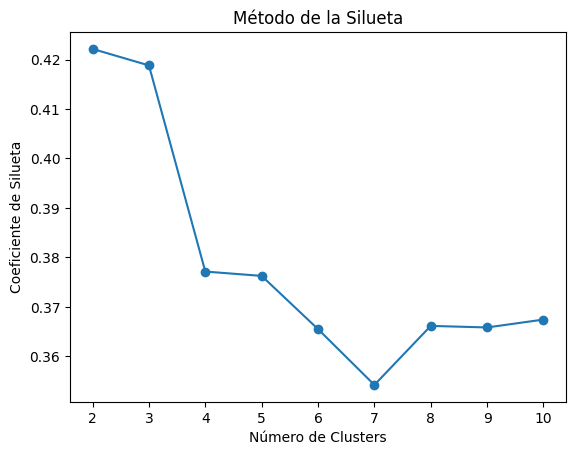

In [100]:
columns=['PCA1','PCA2']

# Crear una lista para almacenar los coeficientes de silueta
silhouette_scores = []

# Definir un rango de posibles números de clusters
k_range = range(2, 11)  # No se puede calcular la silueta para k=1

# Ejecutar K-Means para cada número de clusters en el rango definido
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(volatilidad_sin[columns])  # 'data' es tu conjunto de datos
    silhouette_avg = silhouette_score(volatilidad_sin[columns], labels)
    silhouette_scores.append(silhouette_avg)
    print('K:', k)
    print('Silueta puntaje:', silhouette_scores)

# Graficar el número de clusters contra el coeficiente de silueta
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('Método de la Silueta')
plt.show()

C:\Users\USUARIO\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


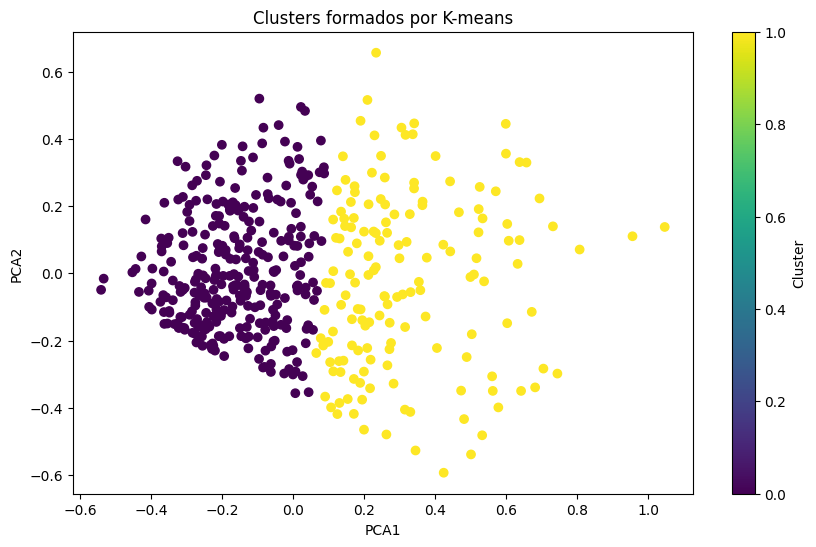

In [101]:
#Implementación del algoritmo de Clusterización
columns=['PCA1','PCA2']

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(volatilidad_sin[columns])

volatilidad_sin['Cluster'] = kmeans.labels_

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(volatilidad_sin['PCA1'], volatilidad_sin['PCA2'], c=volatilidad_sin['Cluster'], cmap='viridis', marker='o')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters formados por K-means')
plt.colorbar(label='Cluster')
plt.show()

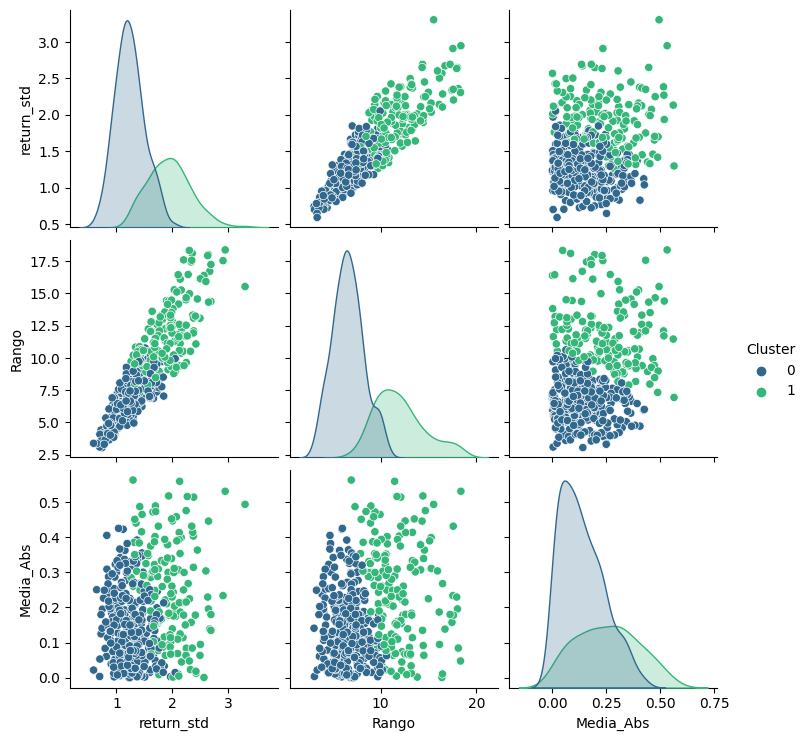

In [102]:
# Ejemplo de variables para graficar pares
variables = ['return_std', 'Rango', 'Media_Abs']

# Crear un DataFrame con las variables seleccionadas y las etiquetas de clúster
df_plot = volatilidad_sin[variables + ['Cluster']]

# Crear pares de gráficos de dispersión usando seaborn
sns.pairplot(df_plot, hue='Cluster', palette='viridis', diag_kind='kde')
plt.show()

In [103]:
volatilidad_sin.head()

,Symbol,return_std,Rango,Media_Abs,return_std_Z,Rango_Z,Media_Abs_Z,return_std_norm,Rango_Norm,Media_Abs_Norm,PCA1,PCA2,Cluster
0,A,1.574247,8.835034,0.091579,0.214605,0.133640,-0.659895,0.362280,0.377505,0.162622,-0.034508,-0.153164,0
2,AAP,2.132842,11.464274,0.559389,1.438953,0.946151,2.984236,0.568243,0.548986,0.993650,0.598468,0.444751,1
3,AAPL,1.258356,7.342810,0.122219,-0.477775,-0.327501,-0.421223,0.245805,0.280182,0.217050,-0.137420,-0.033140,0
4,ABBV,0.861816,3.898611,0.237289,-1.346926,-1.391858,0.475154,0.099594,0.055549,0.421465,-0.271303,0.275245,0
5,ABT,1.132026,5.140155,0.071201,-0.754671,-1.008185,-0.818635,0.199225,0.136523,0.126422,-0.305819,-0.043598,0


Desviación estándar del Retorno:
 Cluster           0           1
mean       1.236536    1.946592
std        0.263937    0.381943
min        0.591706    1.263113
max        2.052086    3.303814
count    302.000000  154.000000


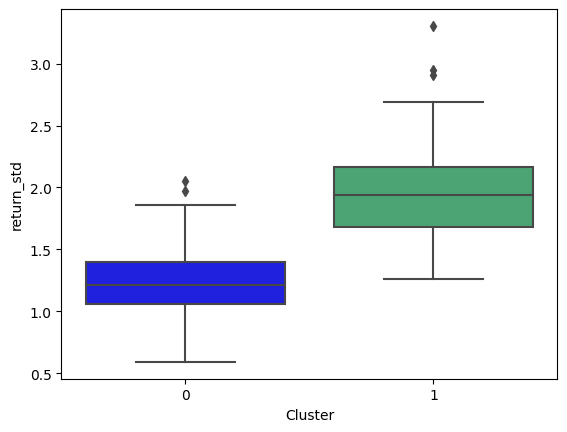

In [104]:
custom_palette = {0: 'blue', 1: 'mediumseagreen'}

print('Desviación estándar del Retorno:\n', volatilidad_sin.groupby('Cluster')['return_std'].aggregate(['mean', 'std', 'min', 'max', 'count']).T)
sns.boxplot(data=volatilidad_sin, x='Cluster', y='return_std', palette=custom_palette)
plt.show()

Rango:
 Cluster           0           1
mean       6.587460   11.962109
std        1.622357    2.589572
min        3.046898    6.937016
max       10.767462   18.379493
count    302.000000  154.000000


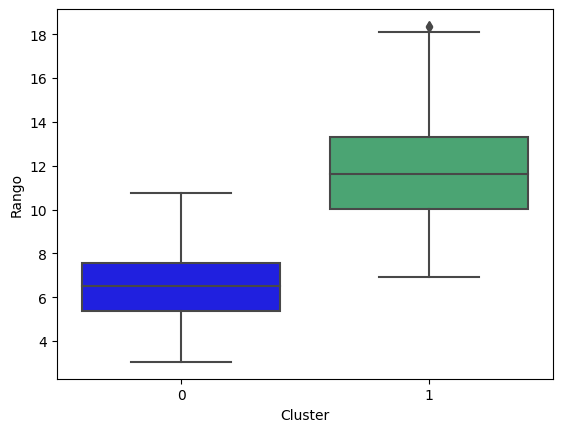

In [105]:
custom_palette = {0: 'blue', 1: 'mediumseagreen'}

print('Rango:\n', volatilidad_sin.groupby('Cluster')['Rango'].aggregate(['mean', 'std', 'min', 'max', 'count']).T)
sns.boxplot(data=volatilidad_sin, x='Cluster', y='Rango', palette=custom_palette)
plt.show()

Promedio Absoluto:
 Cluster           0           1
mean       0.137345    0.252669
std        0.100519    0.142354
min        0.000035    0.000649
max        0.425367    0.562963
count    302.000000  154.000000


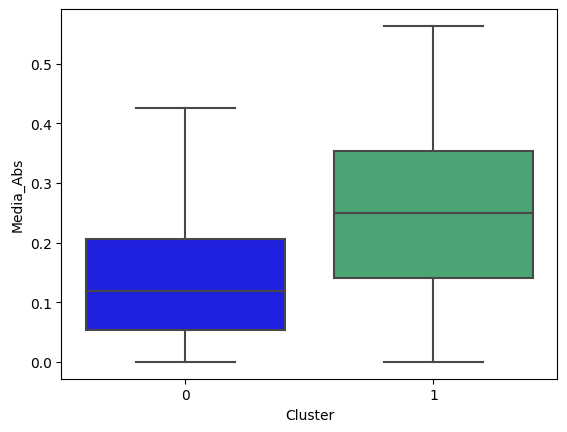

In [106]:
custom_palette = {0: 'blue', 1: 'mediumseagreen'}

print('Promedio Absoluto:\n', volatilidad_sin.groupby('Cluster')['Media_Abs'].aggregate(['mean', 'std', 'min', 'max', 'count']).T)
sns.boxplot(data=volatilidad_sin, x='Cluster', y='Media_Abs', palette=custom_palette)
plt.show()

# Procedimiento e interpretación

## Procedimiento

* En primer lugar se toman los datos de precios de cierre para cada empresa y se calcula el retorno porcentual diario para cada una de ellas. 

* Posteriormente se calculan los indicadores de volatilidad **Desviación estándar del retorno**, **Rango** y **Promedio absoluto** para cada compañía.

* Haciendo un análisis exploratorio de las métricas de volatilidad se encuentran datos atípicos en la métrica de **Rango** los cuales se mantienen incluso al realizar la estandarización y normalización de los datos. Para efectos de no tener unos sesgos tan grandes en los clusters y un mayor error se decide eliminar los datos atípicos según la medida de **Rango**.

* Se realiza la estandarización y normalización de los datos y se decide el uso de los **datos normalizados** para realizar la clusterización.

* Previo a la clusterización se realiza un proceso de reducción de dimensionalidad haciendo uso de un algoritmo `PCA (Principal Component Analysis)` con el fin de obtener dos dimensiones y hacer más fácil la visualización de los clusters. 

* Para el algoritmo de clusterización de `K-Means` se realiza el método de la silueta con el fin de hallar el número óptimo de clusters. Se decide por un total de `2` clusters mediante el **puntaje de silueta** el cual es aproximadamente `0.42`,  el mayor valor entre los grupos analizados. Éste puntaje sirve también como métrica del rendimiento del algoritmo.

* Teniendo los datos de los clusters se realizan gráficos de dispersión para cada uno de los pares de indicadores de volatilidad y estadísticas descriptivas de las métricas agrupadas por los clusters con el fin de hacer una mejor interpretación de la salida de la clusterización.

A continuación se presenta una interpretación de los hallazgos:

## Interpretación

Se obtienen dos clusters en los cuales se puede observar mediante los descriptivos que el  `cluster 0` se corresponde con valores generalmente más bajos en los indicadores: y el `cluster 1` a valores más alto de los indicadores. A continuación se presentan tablas de estadísticos descriptivos para cada grupo: 

* _**Cluster 0**_

| Indicador | Promedio  | Desviación|   Mínimo  |   Máximo  |
|:---------:|:---------:|:---------:| :--------:|:---------:|
| Retorno SD| 1.24      | 0.26      | 0.59      | 2.05      |
| Rango     | 6.59      | 1.62      | 3.05      | 10.77     |
| Promedio Absoluto | 0.14 | 0.10   | 3.5x10^-5 | 0.43      |

* _**Cluster 1**_

| Indicador | Promedio  | Desviación|   Mínimo  |   Máximo  |
|:---------:|:---------:|:---------:| :--------:|:---------:|
| Retorno SD| 1.95      | 0.38      | 1.26      | 3.30      |
| Rango     | 11.96     | 2.59      | 6.94      | 18.38     |
| Promedio Absoluto | 0.25 | 0.14   | 6.4x10^-4 | 0.56      |


teniendo en cuenta que las métricas corresponden a índices de volatilidad, se puede llegar a la siguiente conclusión: 

El `cluster 0`, grupo azul en los gráficos, se corresponde con `Acciones de bajo riesgo` las cuales son más estables, con menos fluctuación en el precio. Invertir en este tipo de acciones se puede aconsejar a un inversionista que no quiera arriesgar tanto su capital, que busque estabilidad y crecimiento moderado ya que la pérdida de la inversión es más cercana a 0.

El `cluster 1`, grupo verde en los gráficos, se corresponde con  `Acciones de alto riesgo` las cuales son más volátiles, o con mayor fluctuación en el precio, lo cual genera más incertidumbre y puede resultar en ganancias más altas o en pérdidas abruptas. Invertir en este tipo de acciones podría ser aconsejable a un inversionista con perfil de alto riesgo con una mayor tolerancia a la pérdida, ya que es el grupo de acciones que permite tener más opciones de ganancia, asumiendo a su vez posibilidad de pérdidas significativas.


